#Código para análise dos dados de Temperatura: Atividade Avaliativa 1.

In [3]:
%%capture

!pip install -U xarray[complete] # reinstala todo o xarray (útil nessa versão do colab por conta do cftime)

!pip install salem  #Instala o salem e o rasterio
!pip install rasterio

!pip install cartopy # Instala o cartopy

!pip install erddapy

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Importa as bibliotecas
import xarray as xr #Biblioteca para netcdf
import numpy as np
import requests #Biblioteca para fazer download direto do link htlm
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import geopandas as gpd
from shapely.geometry import Polygon
import salem #Biblioteca de recorte geoespacial
import cartopy.crs as ccrs #Biblioteca de criação de mapas
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
from scipy import stats

# Download dos dados

## Faz download dos shapefiles direto do link do github.

In [6]:
# URL do arquivo ZIP
url = "https://github.com/andrebelem/pythonverse/raw/main/datasets/SNIRH_UGRHs_2020.zip"

# Nome do arquivo local para salvar
nome_arquivo = "SNIRH_UGRHs_2020.zip"

# Faz o download do arquivo
response = requests.get(url)

# Verifica se a requisição foi bem-sucedida (código 200)
if response.status_code == 200:
    # Abre o arquivo local em modo de escrita em bytes
    with open(nome_arquivo, "wb") as f:
        # Escreve os dados no arquivo
        f.write(response.content)
    print("Download concluído com sucesso!")

Download concluído com sucesso!


## Plotagem da bacia do Paraná

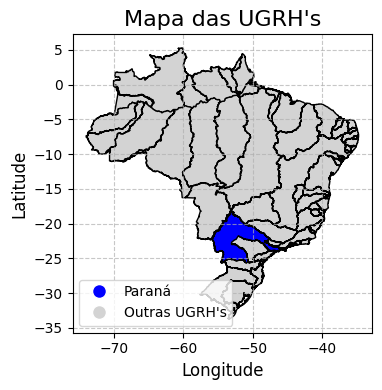

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Carregar os dados
gdf = gpd.read_file("SNIRH_UGRHs_2020.zip")

# Filtrar a bacia desejada (exemplo usando o Paraná)
parana = gdf[gdf.NOME == "Paraná"]

# Criar uma figura e eixo
fig, ax = plt.subplots(figsize=(6, 4))

# Desenhar o mapa das bacias do Brasil
gdf.plot(ax=ax, color='lightgray', edgecolor='black', label="Outras UGRH's")

# Plotar a bacia desejada com destaque
parana.plot(ax=ax, color='blue', edgecolor='black', label='Paraná')

# Personalizar o estilo do mapa
ax.set_title("Mapa das UGRH's", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.set_aspect('equal', adjustable='box')

# Adicionar grade
ax.grid(True, linestyle='--', alpha=0.7)

# Criar elementos para a legenda
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Paraná'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=10, label="Outras UGRH's")]

# Adicionar legenda
ax.legend(handles=legend_elements, loc='lower left')

# Exibir o mapa
plt.tight_layout()
plt.savefig("Mapa_Bacias_Hidrográficas.png")
plt.show()


Dado 1--> GHCN_CAMS Gridded 2m Temperature (Land)


Dado 2 --> NCEP Reanalysis

In [8]:
# Importa o erddapy para fazer download dos dados de precipitação
from erddapy import ERDDAP

#Download dados CHIRPS 0.05°
e = ERDDAP(
  server="https://upwell.pfeg.noaa.gov/erddap",
  protocol="griddap",
  response="opendap"
)
e.dataset_id = "noaa_psl_675a_3cea_522e"
ds_NOAA = e.to_xarray()

In [9]:
url = "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc"
file_name = "air.mon.mean.nc"

response = requests.get(url)

if response.status_code == 200:
    with open(file_name, 'wb') as f:
        f.write(response.content)
    print("Arquivo baixado com sucesso!")
else:
    print("Falha ao baixar o arquivo.")

Arquivo baixado com sucesso!


In [10]:
# Carregar o conjunto de dados
ds_NCEP = xr.open_dataset("air.mon.mean.nc")

In [11]:
#Converte o grid de 0x360 lon para -180x180
ds_NOAA.coords['longitude'] = (ds_NOAA.coords['longitude'] + 180) % 360 - 180
ds_NOAA = ds_NOAA.sortby(ds_NOAA.longitude)

#Converte o grid de 0x360 lon para -180x180
ds_NCEP.coords['lon'] = (ds_NCEP.coords['lon'] + 180) % 360 - 180
ds_NCEP = ds_NCEP.sortby(ds_NCEP.lon)

In [12]:
#Faz um pequeno buffer do shapefile
parana_exp1 = parana.buffer(0.5)
parana_exp2 = parana.buffer(1)

#Transforma para geodataframe para o salem
parana_exp1 = gpd.GeoDataFrame(geometry=parana_exp1)
parana_exp2 = gpd.GeoDataFrame(geometry=parana_exp2)

parana_exp1.crs = parana.crs  # Atribua o mesmo CRS do GeoDataFrame original 'parana'
parana_exp2.crs = parana.crs  # Atribua o mesmo CRS do GeoDataFrame original 'parana'

/tmp/ipython-input-3782663145.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parana_exp1 = parana.buffer(0.5)
/tmp/ipython-input-3782663145.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parana_exp2 = parana.buffer(1)


In [13]:
# Obter os limites do polígono (vértices extremos)
bounds = parana.geometry.bounds

# Extrair coordenadas dos limites
min_x, min_y, max_x, max_y = bounds.minx.min(), bounds.miny.min(), bounds.maxx.max(), bounds.maxy.max()

# Criar um quadrado com base nos limites
quadrado = Polygon([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])

# Criar um GeoDataFrame para o quadrado
quadrado_gdf = gpd.GeoDataFrame(geometry=[quadrado], crs=parana.crs)

In [14]:
#Seleciona os dados de temperatura para meu shapefiel
temp_NOAA = ds_NOAA['air'].salem.subset(shape=quadrado_gdf)
temp_NCEP = ds_NCEP['air'].salem.subset(shape=quadrado_gdf)

temp_NOAA = temp_NOAA.sel(time=slice("1974", "2025"))
temp_NCEP = temp_NCEP.sel(time=slice("1974", "2025"))

temp_NOAA = temp_NOAA.salem.roi(shape=parana_exp1)
temp_NCEP = temp_NCEP.salem.roi(shape=parana_exp2)

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


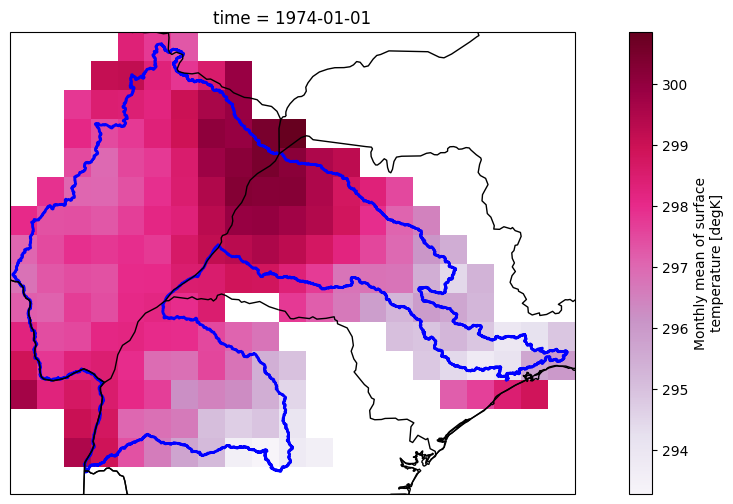

In [15]:
#Verifica o corte do salem para os dados do NOAA
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
temp_NOAA.isel(time=0).plot(ax=ax,
            transform=ccrs.PlateCarree(), x='longitude', y='latitude',
            cmap='PuRd', # altere os valores de vmax para ver o que acontece
            add_colorbar=True)

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_lines')
contries = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_0_countries')

ax.add_feature(states, facecolor='none', edgecolor='black')
ax.add_feature(contries, facecolor='none', edgecolor='black')

parana.geometry.plot(ax=ax,facecolor='none',edgecolor='blue',linewidth=2)

ax.coastlines()

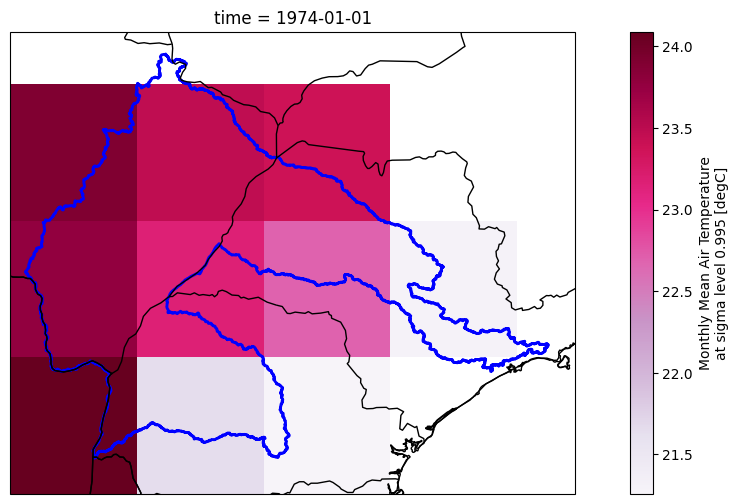

In [16]:
#Verifica o corte do salem para os dados do NCEP
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
temp_NCEP.isel(time=0).plot(ax=ax,
            transform=ccrs.PlateCarree(), x='lon', y='lat',
            cmap='PuRd', # altere os valores de vmax para ver o que acontece
            add_colorbar=True)

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_lines')
contries = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_0_countries')

ax.add_feature(states, facecolor='none', edgecolor='black')
ax.add_feature(contries, facecolor='none', edgecolor='black')

parana.geometry.plot(ax=ax,facecolor='none',edgecolor='blue',linewidth=2)

ax.coastlines()

In [17]:
#Grava no drive por segurança
temp_NCEP.to_netcdf("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/temp_NCEP.nc")
temp_NOAA.to_netcdf("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/temp_NOAA.nc")

# Começar análise daqui

In [18]:
#Abre os arquivos que estavam no drive
temp_NOAA = xr.open_dataset("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/temp_NOAA.nc").air
temp_NCEP = xr.open_dataset("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/temp_NCEP.nc").air
mean_CESM = xr.open_dataset("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/Media_temp_CESMLENS.nc")
mean_CESM["time"] = mean_CESM["time"].astype("datetime64[ns]")

##Análise das tendências de temperatura
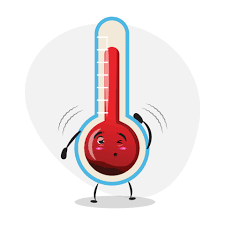







In [19]:
#Faz a médias dos dados da região para fazer a série temporal
mean_NCEP = temp_NCEP.mean(dim=['lat', 'lon'])
mean_NOAA = temp_NOAA.mean(dim=['latitude', 'longitude'])

In [20]:
#Transforma de Kelvin para Celsius
mean_NOAA = mean_NOAA - 273.15

In [21]:
#Faz a média anual para plotar na mesma figura
mean_NCEP_anual = mean_NCEP.groupby('time.year').mean()
mean_NOAA_anual= mean_NOAA.groupby('time.year').mean()
mean_CESM_anual = mean_CESM.groupby('time.year').mean()
mean_NCEP_anual= mean_NCEP_anual.rename({"year" : "time"})
mean_NOAA_anual = mean_NOAA_anual.rename({"year" : "time"})
mean_CESM_anual = mean_CESM_anual.rename({"year" : "time"})

# Converter o tempo para datetime
mean_NCEP_anual['time'] = pd.to_datetime(mean_NCEP_anual['time'], format='%Y')
mean_NOAA_anual['time'] = pd.to_datetime(mean_NOAA_anual['time'], format='%Y')
mean_CESM_anual['time'] = pd.to_datetime(mean_CESM_anual['time'], format='%Y')

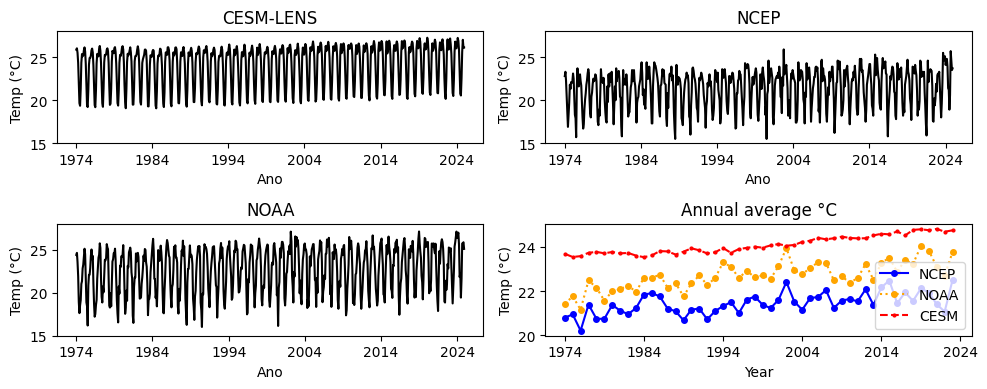

In [22]:
# Criar a figura e os eixos
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))

# Plotar os dados e ajustar o eixo x
(mean_CESM.T).sel(time=slice("1974", "2024")).plot(ax=ax[0, 0], c='black')
(mean_NCEP).sel(time=slice("1974", "2024")).plot(ax=ax[0, 1], c='black')
(mean_NOAA).sel(time=slice("1974", "2024")).plot(ax=ax[1, 0], c='black')

#Plota as médias anuais
(mean_NCEP_anual).sel(time=slice("1974", "2023")).plot(ax=ax[1, 1], label='NCEP', linestyle='-', marker='o', markersize=4, c='blue')
(mean_NOAA_anual).sel(time=slice("1974", "2023")).plot(ax=ax[1, 1], label = 'NOAA', linestyle='dotted', marker='o', markersize=4, c='orange')
(mean_CESM_anual.T).sel(time=slice("1974", "2023")).plot(ax=ax[1, 1], label='CESM', linestyle='--', marker='o',  markersize=2, c='red')

# Configurar os rótulos do eixo x para exibir apenas os anos desejados
for ax_row in ax:
    for ax_col in ax_row:
        years = np.arange(1974, 2025, 10)  # Anos desejados
        years_num = date2num([np.datetime64(str(year), 'Y') for year in years])  # Converter as datas para números
        ax_col.set_xticks(years_num)  # Definir os ticks do eixo x nos anos desejados
        ax_col.set_xticklabels(years)


# Adicionar títulos nos eixos
ax[0, 0].set_xlabel('Ano')
ax[0, 0].set_ylabel('Temp (°C)')
ax[0, 0].set_title('CESM-LENS')
ax[0, 0].set_ylim(15, 28)

ax[0, 1].set_xlabel('Ano')
ax[0, 1].set_ylabel('Temp (°C)')
ax[0, 1].set_title('NCEP')
ax[0, 1].set_ylim(15, 28)

ax[1, 0].set_xlabel('Ano')
ax[1, 0].set_ylabel('Temp (°C)')
ax[1, 0].set_title('NOAA')
ax[1, 0].set_ylim(15, 28)

ax[1, 1].set_xlabel('Year')
ax[1, 1].set_ylabel('Temp (°C)')
ax[1, 1].set_title(' ')
ax[1, 1].set_title("Annual average °C")

# Ajustar o layout
plt.tight_layout()
plt.legend()
# Exibir o plot
plt.savefig("Temperatura_modelos.png")
plt.show()


In [23]:
#Anomalias
anom_NCEP = mean_NCEP - mean_NCEP.sel(time=slice('1980', '2010')).mean(dim='time')
anom_NOAA = mean_NOAA - mean_NOAA.sel(time=slice('1980', '2010')).mean(dim='time')
anom_CESM = mean_CESM - mean_CESM.sel(time=slice('1980', '2010')).mean(dim='time')

In [24]:
#Anomalias para o período
anom_NCEP_filt = anom_NCEP.sel(time=slice("1974", "2024"))
anom_NOAA_filt = anom_NOAA.sel(time=slice("1974", "2024"))
anom_CESM_filt = anom_CESM.T.sel(time=slice("1974", "2024"))

In [25]:
import pandas as pd

# Adicionando uma linha de tendência linear até 2025
anom_year_NCEP = anom_NCEP_filt['time'].dt.year
anom_year_NOAA = anom_NOAA_filt['time'].dt.year
anom_year_CESM = anom_CESM_filt['time'].dt.year

NCEP_coef = np.polyfit(anom_year_NCEP, anom_NCEP_filt, 1)
NOAA_coef = np.polyfit(anom_year_NOAA, anom_NOAA_filt, 1)
CESM_coef = np.polyfit(anom_year_CESM, anom_CESM_filt, 1)

NCEP_trend = np.poly1d(NCEP_coef)
NOAA_trend = np.poly1d(NOAA_coef)
CESM_trend = np.poly1d(CESM_coef)

# Calculando a tendência linear para o período de 1975 a 2025
years_to_plot = pd.date_range(start='1974-01-01', end='2024-01-01', freq='Y')
NCEP_trend_values = NCEP_trend(years_to_plot.year)
noaa_trend_values = NOAA_trend(years_to_plot.year)
CESM_trend_values = CESM_trend(years_to_plot.year)


/tmp/ipython-input-2138000142.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  years_to_plot = pd.date_range(start='1974-01-01', end='2024-01-01', freq='Y')


/tmp/ipython-input-3448693934.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(years_to_plot, NCEP_trend_values, 'b--', label='°C/ano', c='red')
/tmp/ipython-input-3448693934.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[1].plot(years_to_plot, noaa_trend_values, 'b--', label='°C/ano', c='red')
/tmp/ipython-input-3448693934.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[2].plot(years_to_plot, CESM_trend_values, 'b--', label='°C/ano', c='red')


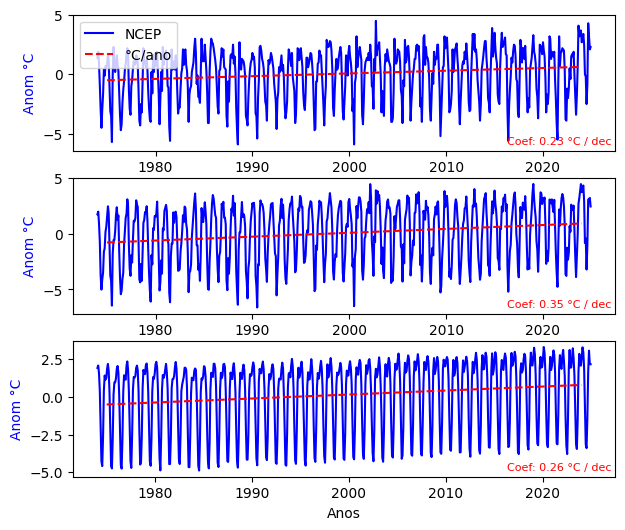

In [26]:
# posso ainda fazer mais uma modificação que é plotaruma linha de tendẽncia nos dois gráficos
# e ajustar a partir de 1975 até o presente (este código foi melhorado com a ajuda do ChatGPT !)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Usando o matplotlib, vou plotar os dois gráficos
fig, ax = plt.subplots(figsize=(7,6), nrows=3)

ax[0].plot(anom_NCEP_filt.time, anom_NCEP_filt, 'b-', label='NCEP')

# Plotando as linhas de tendência
ax[0].plot(years_to_plot, NCEP_trend_values, 'b--', label='°C/ano', c='red')

ax[0].set_xlabel('Anos')
ax[0].set_ylabel('Anom °C', color='b')

# Adicionando as legendas fora do gráfico
ax[0].legend(loc='upper left')

ax[1].plot(anom_NOAA_filt.time, anom_NOAA_filt, 'b-', label='NOAA')

# Plotando as linhas de tendência
ax[1].plot(years_to_plot, noaa_trend_values, 'b--', label='°C/ano', c='red')

ax[1].set_xlabel('Anos')
ax[1].set_ylabel('Anom °C', color='b')

ax[2].plot(anom_CESM_filt.time, anom_CESM_filt, 'b-', label='CESM')

# Plotando as linhas de tendência
ax[2].plot(years_to_plot, CESM_trend_values, 'b--', label='°C/ano', c='red')

ax[2].set_xlabel('Anos')
ax[2].set_ylabel('Anom °C', color='b')

# Adicionando texto com o coeficiente
ax[0].text(0.8, 0.05, f'Coef: {round(NCEP_coef[0]*10, 2)} °C / dec', transform=ax[0].transAxes, fontsize=8, color='red')# Adicionando texto com o coeficiente
ax[1].text(0.8, 0.05, f'Coef: {round(NOAA_coef[0]*10, 2)} °C / dec', transform=ax[1].transAxes, fontsize=8, color='red')
ax[2].text(0.8, 0.05, f'Coef: {round(CESM_coef[0]*10, 2)} °C / dec', transform=ax[2].transAxes, fontsize=8, color='red')

plt.savefig("Anomalias_temperatura.png")
plt.show()

##Tendencia Anual

In [27]:
#Medias anuais
mean_NCEP_anual = mean_NCEP.groupby('time.year').mean()
mean_NOAA_anual= mean_NOAA.groupby('time.year').mean()
mean_CESM_anual = mean_CESM.groupby('time.year').mean()

#Muda o year para time
mean_NCEP_anual = mean_NCEP_anual.rename({"year" : "time"})
mean_NOAA_anual = mean_NOAA_anual.rename({"year" : "time"})
mean_CESM_anual = mean_CESM_anual.rename({"year" : "time"})

In [28]:
#Anomalias anuais
anom_NCEP_anual = mean_NCEP_anual - mean_NCEP_anual.sel(time=slice('1980', '2010')).mean(dim='time')
anom_NOAA_anual = mean_NOAA_anual - mean_NOAA_anual.sel(time=slice('1980', '2010')).mean(dim='time')
anom_CESM_anual = mean_CESM_anual - mean_CESM_anual.sel(time=slice('1980', '2010')).mean(dim='time')

In [29]:
#Anomalias anuais para o período
anom_NCEP_filt = anom_NCEP_anual.sel(time=slice("1974", "2023"))
anom_NOAA_filt = anom_NOAA_anual.sel(time=slice("1974", "2023"))
anom_CESM_filt = anom_CESM_anual.T.sel(time=slice("1974", "2023"))

In [30]:
# Adicionando uma linha de tendência linear até 2025
import numpy as np

anom_year_NCEP = anom_NCEP_filt['time'].values
anom_year_NOAA = anom_NOAA_filt['time'].values
anom_year_CESM = anom_CESM_filt['time'].values

NCEP_coef = np.polyfit(anom_year_NCEP, anom_NCEP_filt, 1)
GPCC_coef = np.polyfit(anom_year_NOAA, anom_NOAA_filt, 1)
CESM_coef = np.polyfit(anom_year_CESM, anom_CESM_filt, 1)

NCEP_trend = np.poly1d(NCEP_coef)
NOAA_trend = np.poly1d(NOAA_coef)
CESM_trend = np.poly1d(CESM_coef)

# Calculando a tendência linear para o período de 1974 a 2023
years_to_plot = np.arange(1974, 2023, 1)
NCEP_trend_values = NCEP_trend(years_to_plot)
NOAA_trend_values = NOAA_trend(years_to_plot)
CESM_trend_values = CESM_trend(years_to_plot)


/tmp/ipython-input-3417016693.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(years_to_plot, NCEP_trend_values, 'b--', label='°C / dec', c='red')
/tmp/ipython-input-3417016693.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[1].plot(years_to_plot, NOAA_trend_values, 'b--', label='°C/dec', c='red')
/tmp/ipython-input-3417016693.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  ax[2].plot(years_to_plot, CESM_trend_values, 'b--', label='°C/dec', c='red')


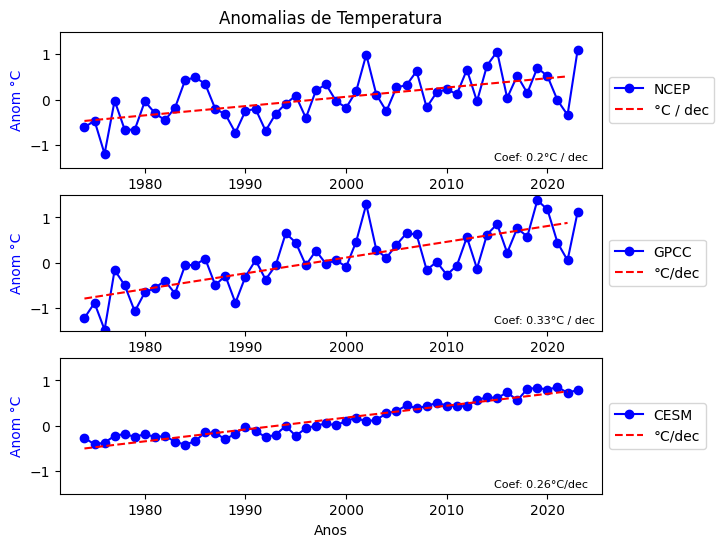

In [31]:
# posso ainda fazer mais uma modificação que é plotaruma linha de tendẽncia nos dois gráficos
# e ajustar a partir de 1975 até o presente (este código foi melhorado com a ajuda do ChatGPT !)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Usando o matplotlib, vou plotar os dois gráficos
fig, ax = plt.subplots(figsize=(7,6), nrows=3)

ax[0].plot(anom_NCEP_filt.time, anom_NCEP_filt, 'b-', label='NCEP', marker='o')

# Plotando as linhas de
ax[0].plot(years_to_plot, NCEP_trend_values, 'b--', label='°C / dec', c='red')

ax[0].set_xlabel('Anos')
ax[0].set_ylabel('Anom °C', color='b')

# Adicionando as legendas fora do gráfico
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Adicionando texto com o coeficiente
ax[0].text(0.8, 0.05, f'Coef: {round(NCEP_coef[0] * 10, 2)}°C / dec', transform=ax[0].transAxes, fontsize=8, color='black')
ax[0].set_title("Anomalias de Temperatura")
ax[0].set_ylim([-1.5, 1.5])

ax[1].plot(anom_NOAA_filt.time, anom_NOAA_filt, 'b-', label='GPCC', marker='o')

# Plotando as linhas de tendência
ax[1].plot(years_to_plot, NOAA_trend_values, 'b--', label='°C/dec', c='red')

ax[1].set_xlabel('Anos')
ax[1].set_ylabel('Anom °C', color='b')
# Adicionando texto com o coeficiente
ax[1].text(0.8, 0.05, f'Coef: {round(GPCC_coef[0] * 10, 2)}°C / dec', transform=ax[1].transAxes, fontsize=8, color='black')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_ylim([-1.5, 1.5])

ax[2].plot(anom_CESM_filt.time, anom_CESM_filt, 'b-', label='CESM', marker='o')

# Plotando as linhas de tendência
ax[2].plot(years_to_plot, CESM_trend_values, 'b--', label='°C/dec', c='red')

ax[2].set_xlabel('Anos')
ax[2].set_ylabel('Anom °C', color='b')
# Adicionando texto com o coeficiente
ax[2].text(0.8, 0.05, f'Coef: {round(CESM_coef[0] * 10, 2)}°C/dec', transform=ax[2].transAxes, fontsize=8, color='black')
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].set_ylim([-1.5, 1.5])

plt.savefig("Anomalias_temp_anuais.png")
plt.show()

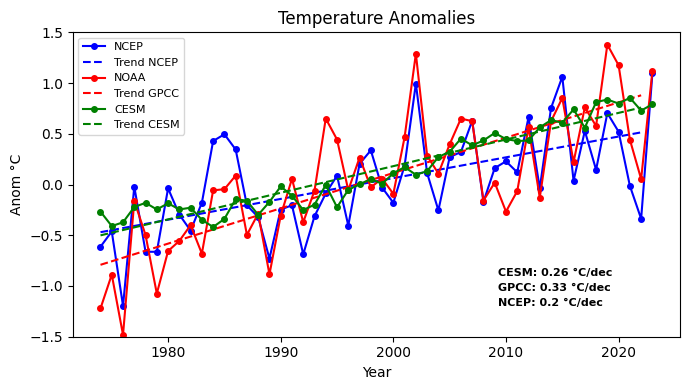

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

# -------------------
# NCEP
# -------------------
ax.plot(anom_NCEP_filt.time, anom_NCEP_filt, 'b-', label='NCEP', marker='o', markersize=4)
ax.plot(years_to_plot, NCEP_trend_values, 'b--', label='Trend NCEP')
ax.text(0.7, 0.10, f'NCEP: {round(NCEP_coef[0]*10,2)} °C/dec',
        transform=ax.transAxes, fontsize=8, color='black', fontweight='bold')

# -------------------
# NOAA / GPCC
# -------------------
ax.plot(anom_NOAA_filt.time, anom_NOAA_filt, 'r-', label='NOAA', marker='o', markersize=4)
ax.plot(years_to_plot, NOAA_trend_values, 'r--', label='Trend GPCC')
ax.text(0.7, 0.15, f'GPCC: {round(GPCC_coef[0]*10,2)} °C/dec',
        transform=ax.transAxes, fontsize=8, color='black', fontweight='bold')

# -------------------
# CESM
# -------------------
ax.plot(anom_CESM_filt.time, anom_CESM_filt, 'g-', label='CESM', marker='o', markersize=4)
ax.plot(years_to_plot, CESM_trend_values, 'g--', label='Trend CESM')
ax.text(0.7, 0.20, f'CESM: {round(CESM_coef[0]*10,2)} °C/dec',
        transform=ax.transAxes, fontsize=8, color='black', fontweight='bold')

# -------------------
# Configurações gerais
# -------------------
ax.set_xlabel('Year')
ax.set_ylabel('Anom °C')
ax.set_title("Temperature Anomalies")
ax.set_ylim([-1.5, 1.5])

# Legenda fora do gráfico
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig("Anomalias_temp_anuais.png")
plt.show()
